### Introduction

Retrieval-augmented generation (RAG) is an NLP model architecture that combines the retrieval-based and generation-based approaches to enable a model’s capability to extract information from a specified document. The language model utilizes user-specific data to pull the relevant information. RAG overcomes the limitations in generating contextually relevant and accurate responses by leveraging the benefits of retrieval mechanisms. This results in more informed and contextually appropriate responses.

LangChain facilitates the implementation of RAG applications, empowering developers to seamlessly replace specific functionalities within an application.

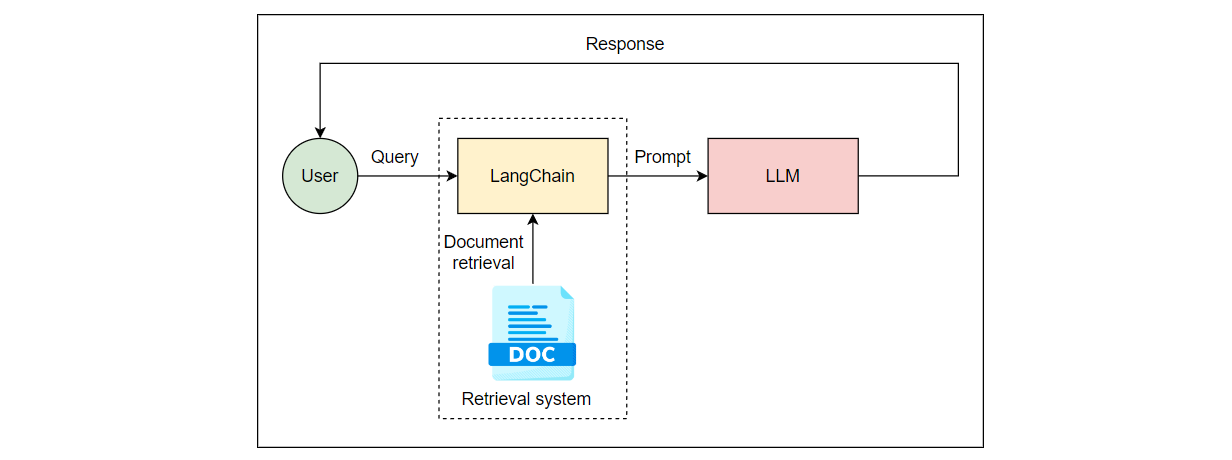

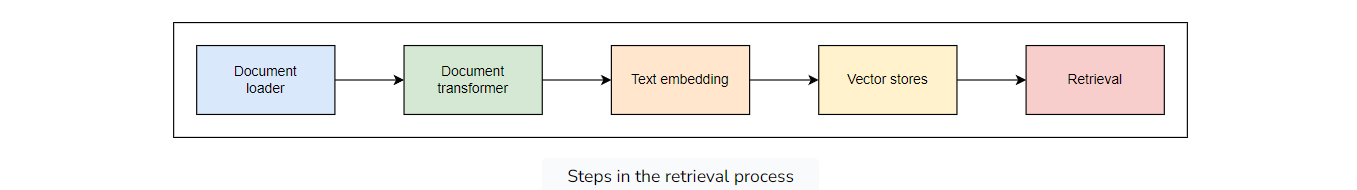

#### 1. Document Loaders

Document loaders load documents from different sources and types, including HTML, PDF, code, and CSV. They also allow support to load private S3 buckets and documents from public websites. This is particularly useful when we wish to retrieve information from any documentation available on external storage.

In [ ]:
#loading data from a text file
from langchain.document_loaders import TextLoader

loader = TextLoader("inputFile.txt")
loader.load()

In [ ]:
#loading data from a csv file
from langchain.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(file_path='inputRecord.csv')
data = loader.load()

In [ ]:
#loading data from a pdf file
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader("inputDocument.pdf")
pages = loader.load_and_split()

#### 2. Document transformers
After loading the document, it’s important to transform it according to our application or model requirements. This is where document transformers come into play. LangChain has various built-in transformers for documents that can perform several operations, including:

1. Splitting
2. Filtering
3. Combining
4. Translating to another language
5. Manipulating data

Let’s look into the simplest transformer that operates splitting. We use text splitters in LangChain for this purpose.

#### Text splitters

When working with a long document, splitting it into smaller pieces is often necessary.

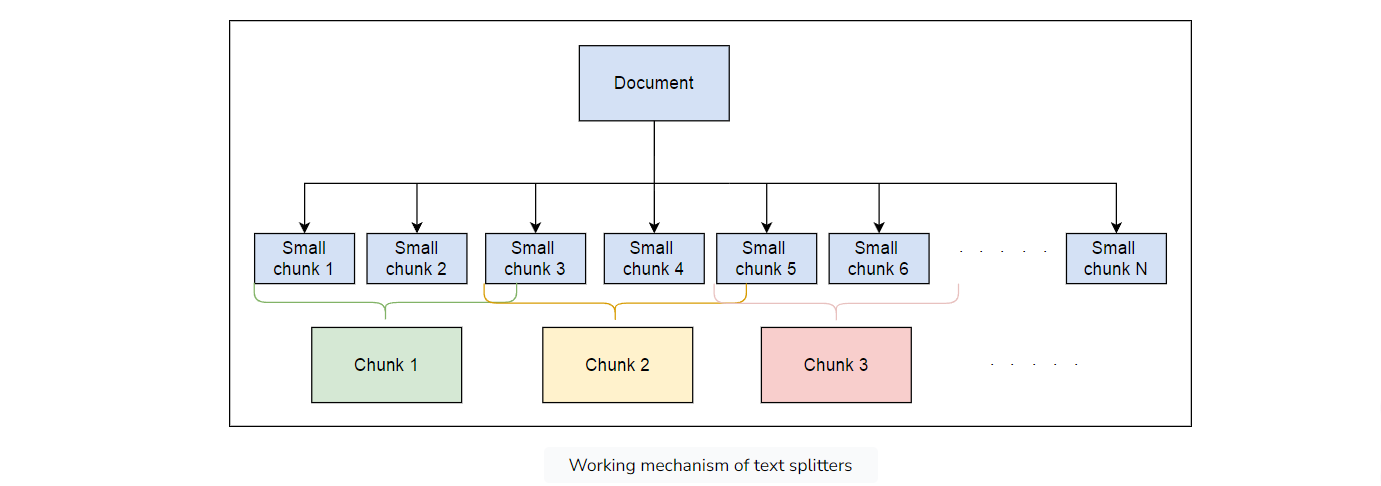

The text splitters follow the steps below:

- Split the document into smaller, readable chunks.

- Combine the small chunks into larger ones to reach the desired chunk size.

- Overlap part of smaller chunks at the boundary to keep the context between chunks.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    # The chunk_size and chunk_overlap can be modified according to the requirements
    length_function = len,
    chunk_size = 200,
    chunk_overlap  = 10,
    add_start_index = True,
)

texts = text_splitter.create_documents([input_document])

### Text embedding models

Embeddings in LangChain help us store the text’s semantic meaning by creating a vector representation, which helps determine similarity with other document texts. For this purpose, LangChain provides the Embeddings class, an interface to interact with all the embedding models. We have several embedding model interfaces, including HuggingFace, OpenAI, Cohere, etc.

**The Embeddings class at a base level provides embeddings using two methods**:

- **Embedding documents**: This embeds multiple documents or texts into their numerical representation.

- **Embedding a query**: This embeds a single query into its numerical embedding. A query can be a text that contains the query we want to search for in the document.

embedded_query = embeddings_model.embed_query("WRITE_YOUR_QUERY_HERE")

### Vector stores

A document may or may not have unstructured data requiring some structuring for the model to access. We most commonly use embeddings to structure that data in a vector space. When a query is passed for retrieving data from the document, the unstructured query is embedded to determine the similarity index (most similar data) between the data present in the vector space and the embedded query. Vector stores perform all of this search process.

**There are two methods for searching the similarity in data stored in vector stores**:

#### 1. Computing a simple similarity index for searching data:

In the simple similarity method, we directly pass the query to the database by computing the similarity index with the most relevant documents and retrieve the most similar result.

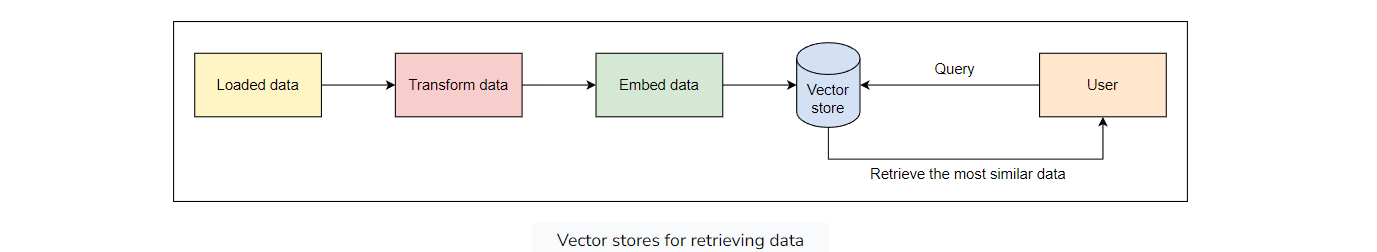

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma

# Load the document
input_document = TextLoader('my_document.txt').load()

# transform the document
text_splitter = RecursiveCharacterTextSplitter(
    # The chunk_size and chunk_overlap can be modified according to the requirements
    length_function = len,
    chunk_size = 200,
    chunk_overlap  = 10,
    add_start_index = True,
)

documents = text_splitter.create_documents([input_document])

# embed the chunks
db = Chroma.from_documents(documents, HuggingFaceEmbeddings())

# user query
query = "WRITE_YOUR_QUERY_HERE"

# computing the search using the similarity_search() method
docs = db.similarity_search(query)

#### 2. Using vector stores to compute the similarity

We can also pass the query after embedding to the vector store to find the similarity index and retrieve data.

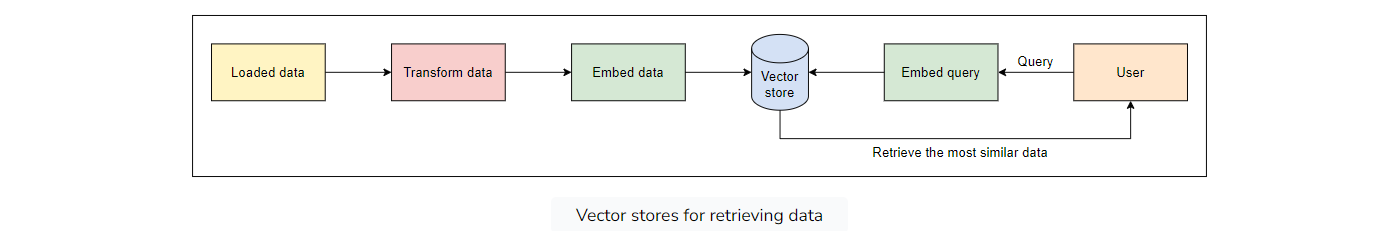

In [ ]:
# user query
query = "WRITE_YOUR_QUERY_HERE"

# embedding the query
embedding_vector = HuggingFaceEmbeddings().embed_query(query)

# computing the search using the search_by_vector() method
docs = db.similarity_search_by_vector(embedding_vector)

### Retrievers

As the name suggests, a retriever has the sole purpose of retrieving data and documents, unlike vector stores, which are also required to store the documents. A retriever can use any backbone for storing documents, including vector stores.

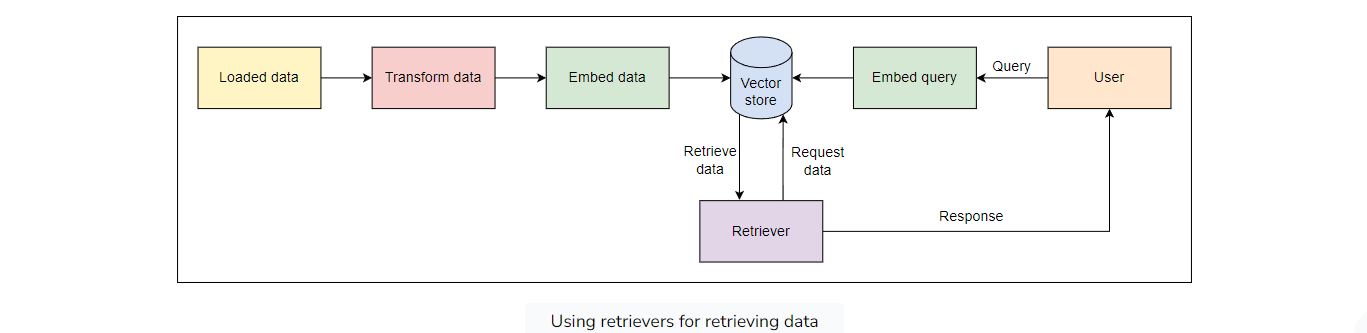

In [ ]:
from langchain.vectorstores import Chroma

db = Chroma.from_texts(texts, embeddings)
retriever = db.as_retriever()

# invoking the retriever 
retrieved_docs = retriever.invoke(
    # write your query here
)

### Hands-On : Question Answering with RAG

In [ ]:
# importing the modules
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.vectorstores import Chroma

# defining the model
llm = HuggingFaceEndpoint(repo_id="meta-llama/Meta-Llama-3-70B-Instruct")

# loading the document
loader = PyPDFLoader("file.pdf")
mypdf = loader.load() 

# Defining the splitter 
document_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap = 70
)

# splitting the document
docs = document_splitter.split_documents(mypdf)

# embedding the chunks to vectorstores
embeddings = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-MiniLM-L6-v2")
persist_directory = 'db'

my_database = Chroma.from_documents(
    documents=docs,
    embedding=embeddings,
    persist_directory=persist_directory
)

# defining the conversational memory
retaining_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

# defining the retriever
question_answering = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=my_database.as_retriever(),
    memory=retaining_memory
)

# defining the loop for a conversation with the AI
while True:
    question = input("Enter your query: ")
    if question == 'exit': 
        break 
    # getting the response
    result = question_answering({"question": "Answer only in the context of the document provided." + question})
    print(result['answer'])